In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from gensim import corpora, models, similarities

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing
from tensorflow.keras.utils import to_categorical

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [6]:
X = df["text"]
y = df["aspect_polarity"]

In [7]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [9]:
X_train = df_train["text"]
y_train = df_train["aspect_polarity"]

In [10]:
X_valid = df_validation["text"]
y_valid = df_validation["aspect_polarity"]

In [11]:
X_test = df_test["text"]
y_test = df_test["aspect_polarity"]

In [12]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [13]:
tokenizer = preprocessing.text.Tokenizer(
        filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower = False,
        split = " "
)
tokenizer.fit_on_texts(X)

In [14]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_valid_tokenizer = tokenizer.texts_to_sequences(X_valid)
X_test_tokenizer = tokenizer.texts_to_sequences(X_test)

In [15]:
max_len = 64
X_train_tokenizer = preprocessing.sequence.pad_sequences(X_train_tokenizer, maxlen=max_len)
X_valid_tokenizer = preprocessing.sequence.pad_sequences(X_valid_tokenizer, maxlen=max_len)
X_test_tokenizer = preprocessing.sequence.pad_sequences(X_test_tokenizer, maxlen=max_len)

In [16]:
input_dim = len(tokenizer.word_index) + 1

In [17]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = models.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)

In [18]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim, output_dim)
        self.position_embeddings = layers.Embedding(sequence_length, output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [19]:
n_class = 3
input_layer = layers.Input(shape=(None,), dtype="int64")
posemb_layer = PositionalEmbedding(max_len, len(tokenizer.word_index) + 1, 256)(input_layer)
transformer_block = TransformerBlock(256, 64, 2)(posemb_layer)
gmaxpool_layer = layers.GlobalMaxPooling1D()(transformer_block)
dropout_layer = layers.Dropout(0.5)(gmaxpool_layer)
output_layer = layers.Dense(n_class, activation="softmax")(dropout_layer)

In [20]:
model = models.Model(input_layer, output_layer)

In [21]:
model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.legacy.Adam(), 
                  metrics=['accuracy'])    

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 positional_embedding (Posit  (None, None, 256)        26550528  
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, None, 256)        560192    
 merBlock)                                                       
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

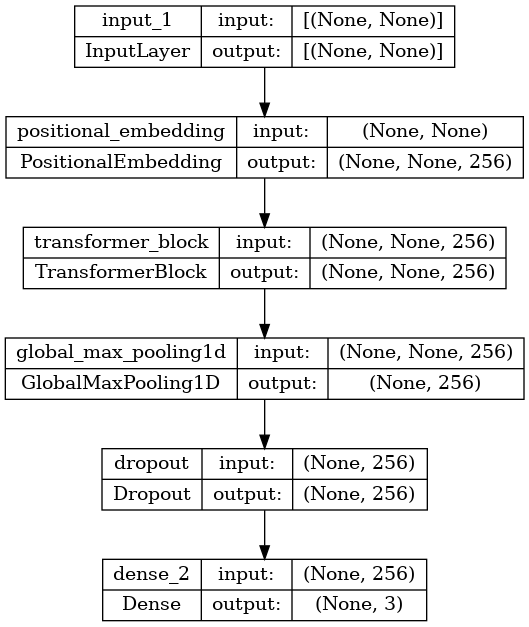

In [23]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True, to_file="output/attention_model_plot.png")

In [24]:
model1_train_start = time.time()
history = model.fit(
    X_train_tokenizer, 
    y_train, 
    epochs=10, 
    batch_size=128, 
    validation_data=[X_valid_tokenizer, y_valid], 
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=3)]
)
model1_train_time = time.time() - model1_train_start
print(f"Attention Train Time = {model1_train_time:.4f}")

Epoch 1/10
1141/1141 [==============================] - 359s 314ms/step - loss: 0.5894 - accuracy: 0.7697 - val_loss: 0.4419 - val_accuracy: 0.8309
Epoch 2/10
1141/1141 [==============================] - 356s 312ms/step - loss: 0.3202 - accuracy: 0.8817 - val_loss: 0.4247 - val_accuracy: 0.8538
Epoch 3/10
1141/1141 [==============================] - 351s 307ms/step - loss: 0.2002 - accuracy: 0.9252 - val_loss: 0.4420 - val_accuracy: 0.8554
Epoch 4/10
1141/1141 [==============================] - 348s 305ms/step - loss: 0.1384 - accuracy: 0.9483 - val_loss: 0.5673 - val_accuracy: 0.8538
Epoch 5/10
1141/1141 [==============================] - 345s 303ms/step - loss: 0.1046 - accuracy: 0.9615 - val_loss: 0.6362 - val_accuracy: 0.8521
Epoch 6/10
1141/1141 [==============================] - 345s 303ms/step - loss: 0.0839 - accuracy: 0.9688 - val_loss: 0.8461 - val_accuracy: 0.8554
Attention Train Time = 2105.6520


In [25]:
model1_test_start = time.time()
model_pred_test = model.predict(X_test_tokenizer, verbose=0)
model1_test_time = time.time() - model1_test_start
print(f"Attention Test Time = {model1_test_time:.4f}")

Attention Test Time = 8.1478


In [26]:
true_labels_train = np.argmax(y_train, axis=1)
true_labels_test = np.argmax(y_test, axis=1)

In [27]:
model_pred_train = model.predict(X_train_tokenizer, verbose=0)
model_pred_train = np.argmax(model_pred_train, axis=1)
model_pred_test = np.argmax(model_pred_test, axis=1)
model_train_score = accuracy_score(model_pred_train, true_labels_train)
model_test_score = accuracy_score(model_pred_test, true_labels_test)
print(f"Attention Train Score = {model_train_score * 100:.4f}%")
print(f"Attention Test Score = {model_test_score * 100:.4f}%")

Attention Train Score = 98.2074%
Attention Test Score = 85.0765%


In [28]:
model_precision_score = precision_score(true_labels_test, model_pred_test, average="macro")
model_f1_score = f1_score(true_labels_test, model_pred_test, average="macro")
model_recall_score = recall_score(true_labels_test, model_pred_test, average="macro")
model_accuracy_score = accuracy_score(true_labels_test, model_pred_test)

print(f"Attention Precision Score = {model_precision_score * 100:.4f}%")
print(f"Attention F1 Score = {model_f1_score * 100:.4f}%")
print(f"Attention Recall Score = {model_recall_score * 100:.4f}%")
print(f"Attention Accuracy Score = {model_accuracy_score * 100:.4f}%")

Attention Precision Score = 76.8018%
Attention F1 Score = 74.8446%
Attention Recall Score = 73.3244%
Attention Accuracy Score = 85.0765%


In [29]:
print(classification_report(true_labels_test, model_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.91      0.88      4508
     Neutral       0.58      0.47      0.52       421
    Positive       0.87      0.82      0.84      3179

    accuracy                           0.85      8108
   macro avg       0.77      0.73      0.75      8108
weighted avg       0.85      0.85      0.85      8108



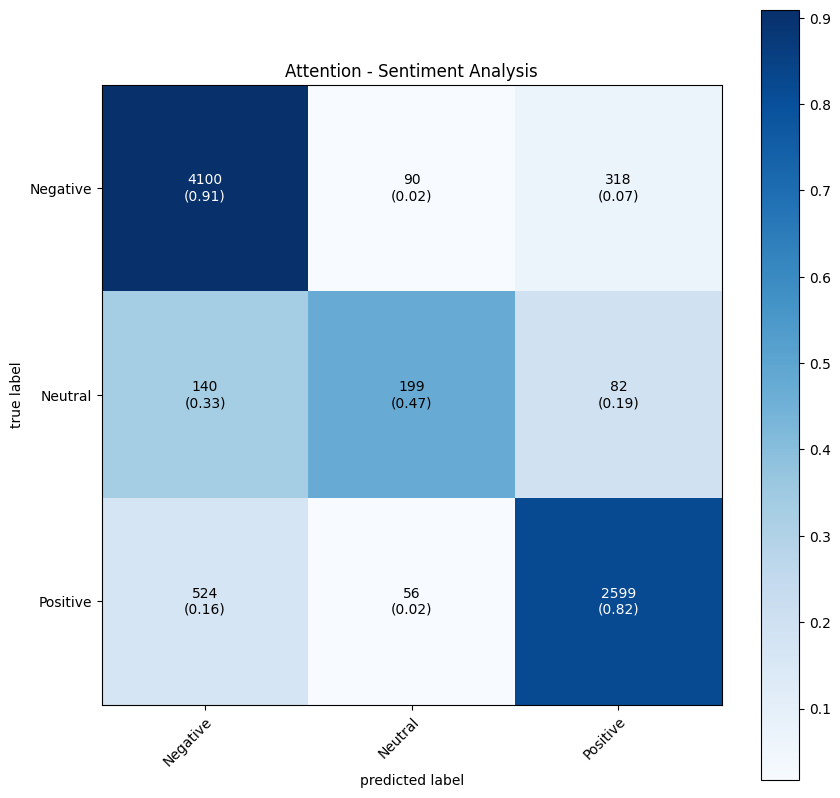

In [30]:
model_cm = confusion_matrix(true_labels_test, model_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=model_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("Attention - Sentiment Analysis")
plt.savefig("./output/attention.png")
plt.show()